In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import joblib
import os
import sys

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from predict.features import (
    PreprocessConvFeatures,
    PreprocessDenseFeatures,
    PreprocessRNNFeatures,
    PreprocessEmbeddingFeatures,
    PreprocessLayerNormFeatures,
    PreprocessAttentionFeatures
)

layer_types = [
    'Convolution',
    'Dense',
    'RNN',
    'Embedding',
    'Attention',
    'LayerNorm'
]

layer_t = layer_types[0]

# Specify the dataset path
dataset_path = f'../data/{layer_t}.csv'

data = pd.read_csv(dataset_path)
data = data.sample(frac=1).reset_index(drop=True)

data = data.dropna()

data

,IT,batchsize,matsize,kernelsize,channels_in,channels_out,strides,padding,precision,activation_fct,...,TMUs,ROPs,SM,TC,RT,PR,TR,FP16,FP32,FP64
0,7892,5,244,6,3,23,2,valid,32,2,...,320,128,80,640,0,176,441,28260,14130,7066
1,13650,10,205,1,45,3,2,same,32,3,...,320,128,80,640,0,176,441,28260,14130,7066
2,2466,56,174,1,46,8,3,valid,32,1,...,160,64,40,320,40,101,254,65130,8141,254
3,14088,43,157,2,26,34,4,valid,32,1,...,224,96,56,0,0,127,297,19050,9526,4763
4,14244,34,262,5,37,7,2,same,32,0,...,320,128,80,640,0,176,441,28260,14130,7066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139992,15681,18,480,2,10,4,1,same,32,3,...,224,96,56,0,0,127,297,19050,9526,4763
139993,8965,20,194,4,32,8,2,same,32,2,...,224,96,56,0,0,127,297,19050,9526,4763
139994,11483,17,17,3,331,233,4,valid,32,3,...,192,96,48,192,48,150,300,19170,19170,300
139995,6868,57,20,2,80,427,4,valid,32,2,...,192,96,48,192,48,150,300,19170,19170,300


In [3]:
data['timeUsed_median'].describe()

count    139997.000000
mean          8.900569
std          21.950270
min           0.047743
25%           1.021876
50%           2.801592
75%           7.555130
max         682.360370
Name: timeUsed_median, dtype: float64

In [4]:
preprocessors = {
    'Convolution': PreprocessConvFeatures,
    'Dense': PreprocessDenseFeatures,
    'RNN': PreprocessRNNFeatures,
    'Embedding': PreprocessEmbeddingFeatures,
    'Attention': PreprocessAttentionFeatures,
    'LayerNorm': PreprocessLayerNormFeatures
}


preprocessor = preprocessors[layer_t](features=data, include_additional_features=True)
features = preprocessor.features

features = features.drop(columns=['GPU'], axis=1)

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

joblib.dump(scaler, f'{layer_t.lower()}_scaler.pkl')

target = data['timeUsed_median']

features

/home/ubuntu/dl-training-time-prediction/predict/features.py:455: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['SGD' 'SGD' 'None' ... 'Adadelta' 'SGD' 'Adagrad']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features.loc[:, 'optimizer'] = self.features['optimizer'].map({0:'None',
/home/ubuntu/dl-training-time-prediction/predict/features.py:462: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['tanh' 'sigmoid' 'relu' ... 'sigmoid' 'tanh' 'sigmoid']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.features.loc[:, 'activation_fct'] = self.features['activation_fct'].map({0:'None',
/home/ubuntu/dl-training-time-prediction/predict/features.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Base Clock (MHz),Boost Clock (MHz),Bus_PCIe 3.0,Bus_PCIe 4.0,Cores,FP32,GPU Memory Bandwidth (GB/s),Memory (GB),Memory Bus (bit),Memory Clock (MHz),...,optimizer_Adagrad,optimizer_Adam,optimizer_None,optimizer_RMSProp,optimizer_SGD,padding_same,padding_valid,precision,strides,use_bias
0,0.208118,-0.722228,0.866042,-0.866042,-0.293622,-0.431245,1.021774,-0.632465,1.154282,-0.767909,...,-0.334447,-0.331482,-0.999279,-0.335305,2.996636,-1.001709,1.001709,0.0,-0.445725,-0.996300
1,0.208118,-0.722228,0.866042,-0.866042,-0.293622,-0.431245,1.021774,-0.632465,1.154282,-0.767909,...,-0.334447,-0.331482,-0.999279,-0.335305,2.996636,0.998294,-0.998294,0.0,-0.445725,-0.996300
2,-1.091199,-0.213776,0.866042,-0.866042,-0.880839,-0.674064,-1.210196,-0.632465,-0.874120,0.212735,...,-0.334447,-0.331482,1.000722,-0.335305,-0.333708,-1.001709,1.001709,0.0,0.449402,-0.996300
3,0.099841,-0.845709,0.866042,-0.866042,-0.645952,-0.617910,0.383516,-0.632465,1.154282,-1.190058,...,-0.334447,-0.331482,-0.999279,-0.335305,-0.333708,-1.001709,1.001709,0.0,1.344529,1.003714
4,0.208118,-0.722228,0.866042,-0.866042,-0.293622,-0.431245,1.021774,-0.632465,1.154282,-0.767909,...,-0.334447,3.016752,-0.999279,-0.335305,-0.333708,0.998294,-0.998294,0.0,-0.445725,-0.996300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139992,0.099841,-0.845709,0.866042,-0.866042,-0.645952,-0.617910,0.383516,-0.632465,1.154282,-1.190058,...,-0.334447,-0.331482,1.000722,-0.335305,-0.333708,0.998294,-0.998294,0.0,-1.340853,1.003714
139993,0.099841,-0.845709,0.866042,-0.866042,-0.645952,-0.617910,0.383516,-0.632465,1.154282,-1.190058,...,-0.334447,-0.331482,-0.999279,-0.335305,2.996636,0.998294,-0.998294,0.0,-0.445725,1.003714
139994,-0.795899,-0.286412,-1.154679,1.154679,-0.058735,-0.226904,-0.715062,-0.632465,-0.874120,1.523756,...,-0.334447,-0.331482,-0.999279,-0.335305,-0.333708,-1.001709,1.001709,0.0,1.344529,1.003714
139995,-0.795899,-0.286412,-1.154679,1.154679,-0.058735,-0.226904,-0.715062,-0.632465,-0.874120,1.523756,...,-0.334447,-0.331482,-0.999279,-0.335305,2.996636,-1.001709,1.001709,0.0,1.344529,1.003714


In [5]:
data.describe()

,IT,batchsize,matsize,kernelsize,channels_in,channels_out,strides,precision,activation_fct,optimizer,...,TMUs,ROPs,SM,TC,RT,PR,TR,FP16,FP32,FP64
count,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.0,139997.000000,139997.000000,...,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000,139997.000000
mean,9999.531340,32.460210,256.562512,3.983635,67.119045,67.596534,2.497946,32.0,1.505747,1.502325,...,267.429502,105.143053,66.857376,272.005829,39.429416,183.858361,481.289663,37647.541376,24766.469439,2701.241534
std,5773.516755,18.506996,147.845789,2.005502,327.698673,331.536048,1.117164,0.0,1.118742,1.804802,...,109.763278,34.056836,27.440820,223.836331,43.104280,108.318788,339.785946,23753.761542,24664.623415,2570.856213
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.0,0.000000,0.000000,...,160.000000,64.000000,40.000000,0.000000,0.000000,101.000000,254.000000,19050.000000,8141.000000,254.000000
25%,5000.000000,16.000000,129.000000,2.000000,10.000000,10.000000,1.000000,32.0,1.000000,0.000000,...,192.000000,80.000000,48.000000,0.000000,0.000000,127.000000,297.000000,19050.000000,9526.000000,300.000000
50%,10000.000000,32.000000,256.000000,4.000000,19.000000,19.000000,2.000000,32.0,2.000000,1.000000,...,224.000000,96.000000,56.000000,240.000000,40.000000,150.000000,300.000000,28260.000000,14130.000000,1290.000000
75%,14999.000000,49.000000,385.000000,6.000000,38.000000,39.000000,3.000000,32.0,3.000000,3.000000,...,320.000000,128.000000,80.000000,512.000000,60.000000,176.000000,490.000000,65130.000000,30290.000000,4763.000000
max,19999.000000,64.000000,512.000000,7.000000,9977.000000,9957.000000,4.000000,32.0,3.000000,5.000000,...,512.000000,176.000000,128.000000,640.000000,128.000000,443.000000,1290.000000,82580.000000,82580.000000,7066.000000


In [6]:
preprocessor.get_features_list()

['Base Clock (MHz)',
 'Boost Clock (MHz)',
 'Bus_PCIe 3.0',
 'Bus_PCIe 4.0',
 'Cores',
 'FP32',
 'GPU',
 'GPU Memory Bandwidth (GB/s)',
 'Memory (GB)',
 'Memory Bus (bit)',
 'Memory Clock (MHz)',
 'Memory Type_GDDR5',
 'Memory Type_GDDR6',
 'Memory Type_GDDR6X',
 'Memory Type_HBM2',
 'RT',
 'TC',
 'activation_fct_None',
 'activation_fct_relu',
 'activation_fct_sigmoid',
 'activation_fct_tanh',
 'batchsize',
 'channels_in',
 'channels_out',
 'flops',
 'flops/speed',
 'kernelsize',
 'matsize',
 'memory_in',
 'memory_out',
 'memory_total',
 'memory_weights',
 'optimizer_Adadelta',
 'optimizer_Adagrad',
 'optimizer_Adam',
 'optimizer_None',
 'optimizer_RMSProp',
 'optimizer_SGD',
 'padding_same',
 'padding_valid',
 'precision',
 'strides',
 'use_bias']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred_linear_regression = linear_regression.predict(X_test)
rms_linear_regression = rmse(y_test, y_pred_linear_regression)
print(f'Linear Regression RMS: {rms_linear_regression:.3f} ms')


# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rms_rf = rmse(y_test, y_pred_rf)
print(f'Random Forest RMS: {rms_rf:.3f} ms')


# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
rms_gb = rmse(y_test, y_pred_gb)
print(f'Gradient Boosting RMS: {rms_gb:.3f} ms')


# XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rms_xgb = rmse(y_test, y_pred_xgb)
print(f'XGBoost RMS: {rms_xgb:.3f} ms')

Linear Regression RMS: 14.081 ms
Random Forest RMS: 8.209 ms
Gradient Boosting RMS: 9.404 ms
XGBoost RMS: 8.543 ms


In [11]:
from torch.utils.data import TensorDataset, DataLoader
import torch

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

num_epochs = 300
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [12]:
from prediction_models import (
    MLP
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(input_size=X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)


for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = mlp(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}] Loss: {epoch_loss/len(train_loader):.4f}')

/home/ubuntu/miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  3%|▎         | 10/300 [00:47<22:43,  4.70s/it]

Epoch [9/300] Loss: 76.0813


  7%|▋         | 20/300 [01:34<21:19,  4.57s/it]

Epoch [19/300] Loss: 64.6660


 10%|█         | 30/300 [02:22<21:14,  4.72s/it]

Epoch [29/300] Loss: 60.8602


 13%|█▎        | 40/300 [03:09<20:49,  4.81s/it]

Epoch [39/300] Loss: 52.0664


 17%|█▋        | 50/300 [03:55<18:26,  4.43s/it]

Epoch [49/300] Loss: 48.0540


 20%|██        | 60/300 [04:39<17:17,  4.32s/it]

Epoch [59/300] Loss: 43.7044


 23%|██▎       | 70/300 [05:24<17:20,  4.52s/it]

Epoch [69/300] Loss: 41.5203


 27%|██▋       | 80/300 [06:10<16:49,  4.59s/it]

Epoch [79/300] Loss: 38.8794


 30%|███       | 90/300 [06:54<15:04,  4.31s/it]

Epoch [89/300] Loss: 34.8332


 33%|███▎      | 100/300 [07:38<15:00,  4.50s/it]

Epoch [99/300] Loss: 33.3802


 37%|███▋      | 110/300 [08:22<13:25,  4.24s/it]

Epoch [109/300] Loss: 34.4587


 40%|████      | 120/300 [09:03<12:33,  4.19s/it]

Epoch [119/300] Loss: 29.6114


 43%|████▎     | 130/300 [09:47<12:33,  4.43s/it]

Epoch [129/300] Loss: 30.4555


 47%|████▋     | 140/300 [10:31<11:45,  4.41s/it]

Epoch [139/300] Loss: 26.6518


 50%|█████     | 150/300 [11:15<11:14,  4.49s/it]

Epoch [149/300] Loss: 26.7417


 53%|█████▎    | 160/300 [12:01<10:45,  4.61s/it]

Epoch [159/300] Loss: 25.8337


 57%|█████▋    | 170/300 [12:47<09:42,  4.48s/it]

Epoch [169/300] Loss: 24.6340


 60%|██████    | 180/300 [13:32<09:15,  4.63s/it]

Epoch [179/300] Loss: 23.1033


 63%|██████▎   | 190/300 [14:19<08:44,  4.77s/it]

Epoch [189/300] Loss: 22.5686


 67%|██████▋   | 200/300 [15:02<07:19,  4.40s/it]

Epoch [199/300] Loss: 21.8915


 70%|███████   | 210/300 [15:47<06:33,  4.37s/it]

Epoch [209/300] Loss: 21.9221


 73%|███████▎  | 220/300 [16:32<06:03,  4.54s/it]

Epoch [219/300] Loss: 20.3478


 77%|███████▋  | 230/300 [17:17<05:06,  4.38s/it]

Epoch [229/300] Loss: 20.0211


 80%|████████  | 240/300 [18:02<04:25,  4.42s/it]

Epoch [239/300] Loss: 19.8543


 83%|████████▎ | 250/300 [18:45<03:36,  4.33s/it]

Epoch [249/300] Loss: 19.1044


 87%|████████▋ | 260/300 [19:31<03:04,  4.60s/it]

Epoch [259/300] Loss: 17.9659


 90%|█████████ | 270/300 [20:16<02:14,  4.48s/it]

Epoch [269/300] Loss: 17.9134


 93%|█████████▎| 280/300 [21:01<01:28,  4.42s/it]

Epoch [279/300] Loss: 16.9056


 97%|█████████▋| 290/300 [21:47<00:45,  4.51s/it]

Epoch [289/300] Loss: 16.9317


100%|██████████| 300/300 [22:31<00:00,  4.50s/it]

Epoch [299/300] Loss: 16.7227


In [13]:
mlp.eval()  # Set the model to evaluation mode

y_true = []
y_pred_mlp = []

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, targets in tqdm(test_loader):  # Iterate over test_loader batches 
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = mlp(inputs).cpu().numpy()  # Get predictions and move to CPU
        y_true.extend(targets.cpu().numpy())  # Add actual values to list
        y_pred_mlp.extend(outputs)  # Add predictions to list

# Compute RMS error
rms_mlp = rmse(y_true, y_pred_mlp)
print(f'Feedforward Neural Network RMS: {rms_mlp:.3f} ms')

torch.save(mlp, f'{layer_t.lower()}_mlp.pth')

100%|██████████| 219/219 [00:00<00:00, 299.92it/s]

Feedforward Neural Network RMS: 9.341 ms


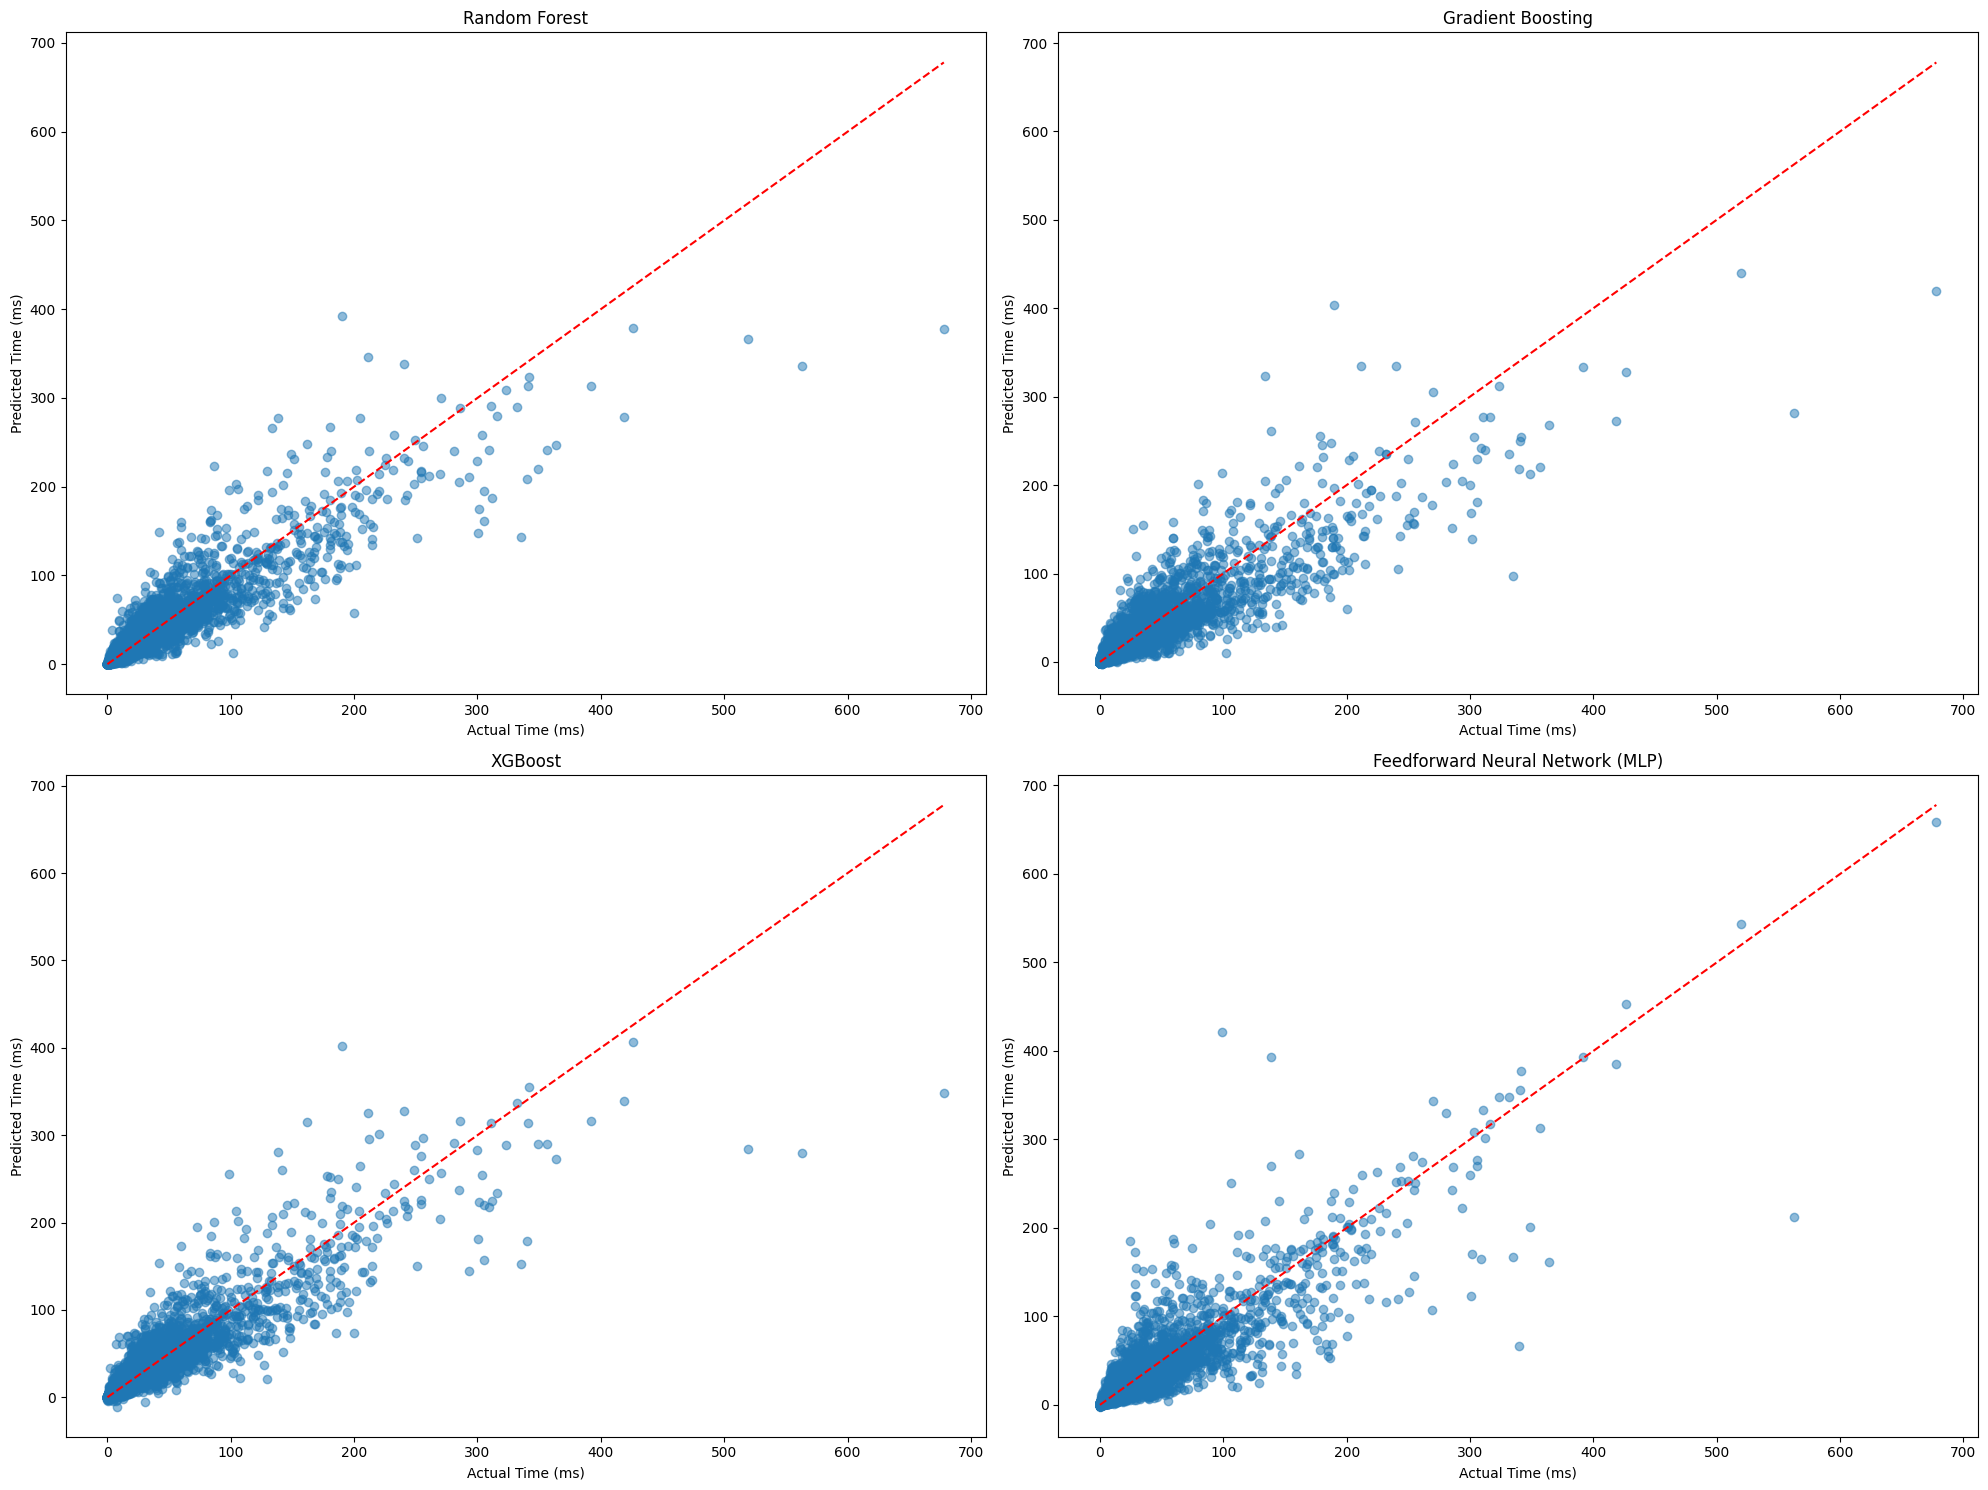

In [14]:
# Plot predicted vs actual values for all models
plt.figure(figsize=(20, 15))

# Random Forest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# Gradient Boosting
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Gradient Boosting')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# XGBoost
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('XGBoost')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

# Feedforward Neural Network (MLP)
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Feedforward Neural Network (MLP)')
plt.xlabel('Actual Time (ms)')
plt.ylabel('Predicted Time (ms)')

plt.tight_layout()
plt.show()